In [1]:
import pandas as pd
import numpy as np

# text-preprocessing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')  # Correct resource name
nltk.download('wordnet')
nltk.download('stopwords')

# model building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sezai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\sezai\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sezai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sezai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data_paths = {
    'train': 'data/train.csv',
    'test': 'data/test.csv',
    'sample_submission': 'data/sample_submission.csv'
}

def load_data():
    train_df = pd.read_csv(data_paths['train'])
    test_df = pd.read_csv(data_paths['test'])
    sample_submission_df = pd.read_csv(data_paths['sample_submission'])
    
    return train_df, test_df, sample_submission_df

In [3]:
train_df, test_df, sample_submission_df = load_data()

# See if our DF is loaded correctly
print("Train DataFrame shape:", train_df.shape)
train_df.head()

print('Info for train_df:')
train_df.info()

print('Info for test_df:')
test_df.info()

Train DataFrame shape: (7613, 5)
Info for train_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
Info for test_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


We have null values in our data.

Class distribution in training data:
target
0    4342
1    3271
Name: count, dtype: int64


<Axes: xlabel='target'>

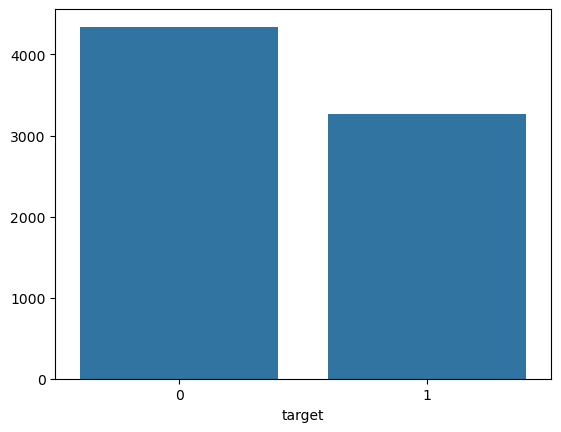

In [4]:
import seaborn as sns

# check the class distribution
print("Class distribution in training data:")
x = train_df['target'].value_counts()
print(x)

sns.barplot(x=x.index, y=x.values)

In [5]:
train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
# find the wordcount for each text
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))

print(train_df[train_df['target'] == 1]['word_count'].mean()) # disaster
print(train_df[train_df['target'] == 0]['word_count'].mean()) # non-disaster

15.167532864567411
14.704744357438969


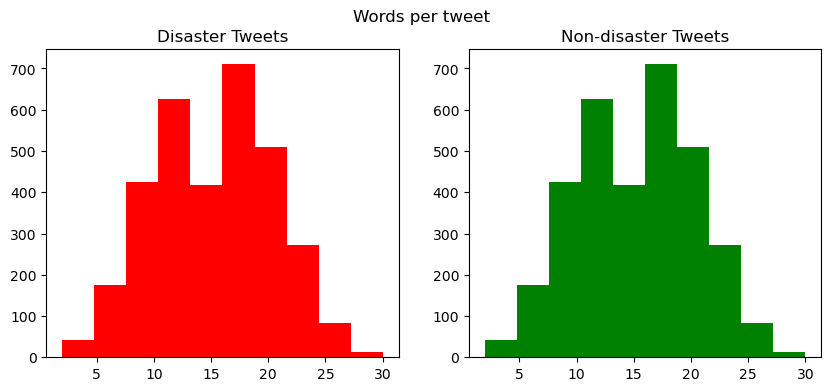

15.167532864567411 14.704744357438969


In [7]:
import matplotlib.pyplot as plt

# plotting the word count
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
train_words_disaster = train_df[train_df['target'] == 1]['word_count']
ax1.hist(train_words_disaster, color = 'red')
ax1.set_title('Disaster Tweets')

train_words_nondisaster = train_df[train_df['target'] == 0]['word_count']
ax2.hist(train_words_disaster, color = 'green')
ax2.set_title('Non-disaster Tweets')

fig.suptitle('Words per tweet')
plt.show()

print(train_words_disaster.mean(), train_words_nondisaster.mean())

## Moving onto Text-Preprocessing
We will use nltk, string, re etc. to
- Remove punctuations
- Remove leading and trailing (extra) spaces
- Remove stop words
- Remove typos and stemming them

In [8]:
def lower_strip(text):
    return text.lower().strip()

# convert to lowercase, strip and remove punctiations
def preprocess(text):
    text = lower_strip(text)
    text = re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]', ' ', text)
    text = re.sub(r'[^\w\s]', '', lower_strip(str(text)))
    text = re.sub(r'\d', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    return text

def stopword(string):
    a = [i for i in string.split() if i not in stopwords.words('english')]

    return ' '.join(a)

In [9]:
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [10]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

train_df['clean_text'] = train_df['text'].apply(lambda x: finalpreprocess(x))
train_df.head()

,id,keyword,location,text,target,word_count,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,get sent photo ruby alaska smoke wildfires pou...


## Extracting vectors from text
it is difficult to work with text data directly, so we will convert the text into vectors.

In [11]:
# splitting the data in to train and test data
X_train, X_test, y_train, y_test = train_test_split(train_df['clean_text'], train_df['target'], test_size=0.2, shuffle=True)

# word2vec
X_train_tok = [nltk.word_tokenize(i) for i in X_train]
X_test_tok = [nltk.word_tokenize(i) for i in X_test]

In [13]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

#building Word2Vec model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
    
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

# Create tokenized versions of clean_text for training
train_df['clean_text_tok'] = [nltk.word_tokenize(i) for i in train_df['clean_text']]

# Train Word2Vec model
model = Word2Vec(train_df['clean_text_tok'], min_count=1)

# Convert Word2Vec model to dictionary format
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))

# Create vectorizer
modelw = MeanEmbeddingVectorizer(w2v)

# Converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_test_vectors_w2v = modelw.transform(X_test_tok)

In [14]:
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.81      0.82      0.81       877
           1       0.75      0.73      0.74       646

    accuracy                           0.78      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.78      0.78      0.78      1523

Confusion Matrix: [[719 158]
 [174 472]]
AUC: 0.8527037713002743


In [15]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       877
           1       0.84      0.64      0.73       646

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.78      1523
weighted avg       0.80      0.80      0.79      1523

Confusion Matrix: [[800  77]
 [232 414]]
AUC: 0.8546259588874259


In [17]:
#Pre-processing the new dataset
test_df['clean_text'] = test_df['text'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=test_df['clean_text'] 
#converting words to numerical data using tf-idf
X_vector=tfidf_vectorizer.transform(X_test)
#use the best model to predict 'target' value for the new dataset 
y_predict = lr_tfidf.predict(X_vector)      
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
test_df['predict_prob']= y_prob
test_df['target']= y_predict
final=test_df[['clean_text','target']].reset_index(drop=True)
print(final.head())

                                          clean_text  target
0                          happen terrible car crash       1
1  heard earthquake different city stay safe ever...       1
2  forest fire spot pond geese flee across street...       1
3                  apocalypse light spokane wildfire       1
4                 typhoon soudelor kill china taiwan       1


You can further enhance the performance of your model using this code by

- using other classification algorithms like Support Vector Machines (SVM), XgBoost, Ensemble models, Neural networks etc.
- using Gridsearch to tune the hyperparameters of your model
- using advanced word-embedding methods like GloVe and BERT